
# Transfer Learning on TF Flowers Dataset using MobileNetV2
 
This notebook demonstrates transfer learning using **MobileNetV2** on the **TensorFlow Flowers Dataset**.
 
We'll:
- Load and preprocess the dataset
- Apply data augmentation
- Build a transfer learning model
- Train it with early stopping
- Evaluate and visualize performance

**Author:** Soumil Malik  
**Framework:** TensorFlow / Keras  
**Dataset:** `tf_flowers` (5 classes)


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers #type: ignore
import tensorflow_datasets as tfds #type: ignore
import matplotlib.pyplot as plt

## Step 1: Load Dataset

In [4]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

train_size = int(0.8 * info.splits["train"].num_examples)
val_size = int(0.1 * info.splits["train"].num_examples)
test_size = int(0.1 * info.splits["train"].num_examples)

train_ds = dataset["train"].take(train_size)
val_ds = dataset["train"].skip(train_size).take(val_size)
test_ds = dataset["train"].skip(train_size + val_size).take(test_size)

print("Total examples:", info.splits["train"].num_examples)
print("Train:", train_size, "| Val:", val_size, "| Test:", test_size)

d:\40-Days-DL-MLOps\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 1/1 [00:17<00:00, 17.28s/ url]


Dataset tf_flowers downloaded and prepared to C:\Users\Asus\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.
Total examples: 3670
Train: 2936 | Val: 367 | Test: 367


## Step 2: Preprocessing & Data Augmentation

In [5]:
IMG_SIZE = 160
BATCH_SIZE = 32

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Step 3: Load Pretrained Base (MobileNetV2)

In [6]:
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Step 4: Build Transfer Learning Model

In [7]:
model = keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(5, activation="softmax")
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Step 5: Compile the Model

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

## Step 6: Train the Model (with Early Stopping)

In [9]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.5950 - loss: 1.0986 - val_accuracy: 0.7984 - val_loss: 0.5586
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 508ms/step - accuracy: 0.7847 - loss: 0.6084 - val_accuracy: 0.8338 - val_loss: 0.4370
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 489ms/step - accuracy: 0.8188 - loss: 0.4983 - val_accuracy: 0.8692 - val_loss: 0.3522
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 496ms/step - accuracy: 0.8416 - loss: 0.4322 - val_accuracy: 0.8583 - val_loss: 0.3788
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 488ms/step - accuracy: 0.8460 - loss: 0.4086 - val_accuracy: 0.8774 - val_loss: 0.3242
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 493ms/step - accuracy: 0.8546 - loss: 0.3864 - val_accuracy: 0.8910 - val_loss: 0.3177
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 488ms/step - accuracy: 0.8716 - loss: 0.3537 - val_accuracy: 0.8937 - val_loss: 0.3150
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 488ms/step - accuracy: 0.8808 - loss: 0.3520 - val_accu

##  Step 7: Evaluate the Model

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print("✅ Final Test Accuracy:", round(test_acc * 100, 2), "%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 0.9074 - loss: 0.2585
✅ Final Test Accuracy: 90.74 %


## Step 8: Plot Accuracy Graph

d:\40-Days-DL-MLOps\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


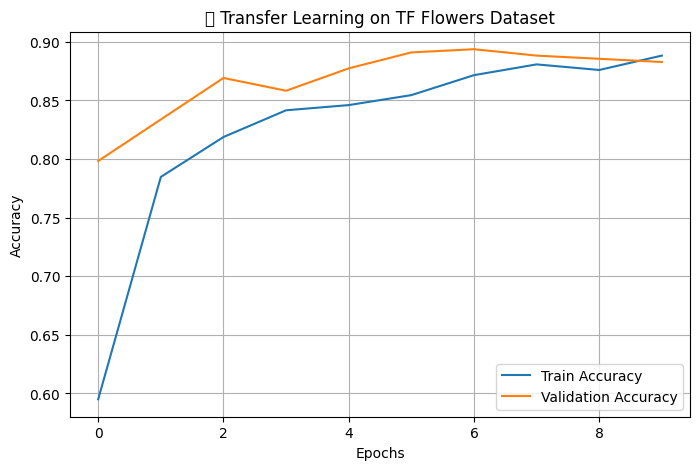

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("📊 Transfer Learning on TF Flowers Dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Results Summary

- Model: **MobileNetV2 (frozen base)**  
- Epochs: 10 (EarlyStopped)  
- Batch Size: 32  
- Image Size: 160×160  

**Final Test Accuracy:** *Displayed Above*  

---

**Next Steps:**
- Fine-tune the last few layers of `MobileNetV2`
- Try other pretrained models (e.g., EfficientNet, ResNet50)
- Add learning rate scheduling for improved convergence